In [19]:
from joblib import dump, load
from itertools import combinations
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [2]:
X = pd.read_csv('../data/PPMI_sncRNAcounts/counts/X.csv')
y = pd.read_csv('../data/PPMI_sncRNAcounts/counts/y.csv')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)
y_score = model.predict_proba(X_test)

In [7]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

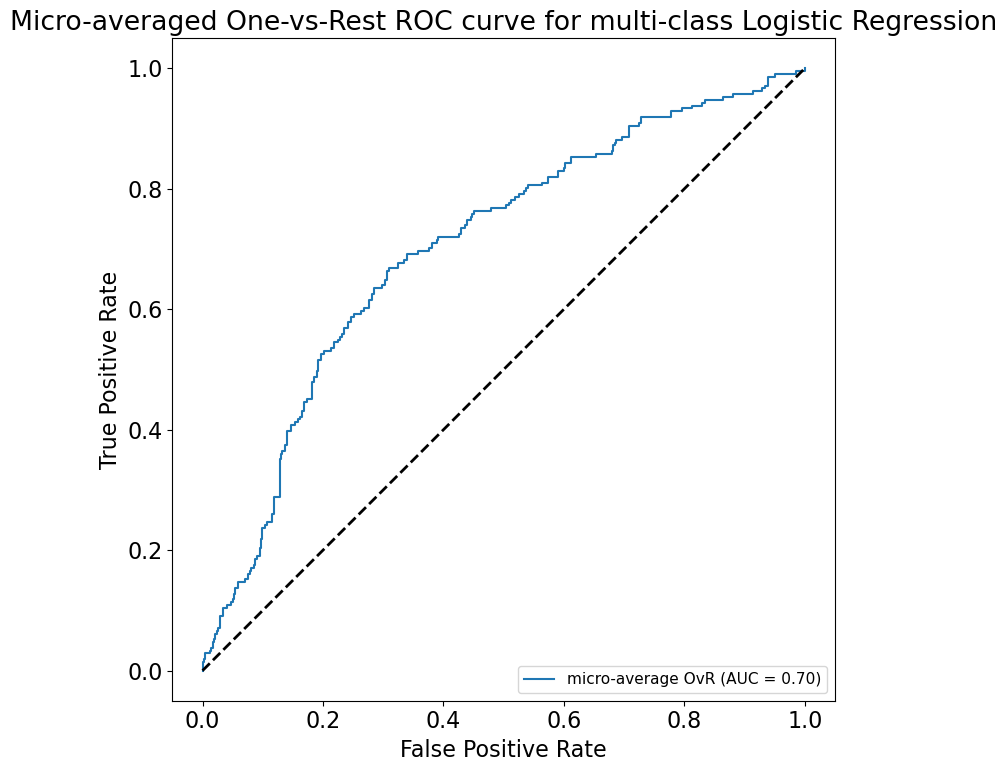

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
RocCurveDisplay.from_predictions(y_onehot_test.ravel(), y_score.ravel(), name='micro-average OvR', ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')
ax.axis('square')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Micro-averaged One-vs-Rest ROC curve for multi-class Logistic Regression') 
ax.legend(loc="lower right", fontsize='11')
fig.tight_layout()
fig.savefig('../figures/roc_ovr_multi_class_logistic_regression.png', dpi=600)
plt.show()

In [9]:
pair_list = [(1, 4), (2, 4), (1, 2)]

In [10]:
fpr_grid = np.linspace(0.0, 1.0, 1000)
target_names = ['PD', 'healthy', 'prodromal']

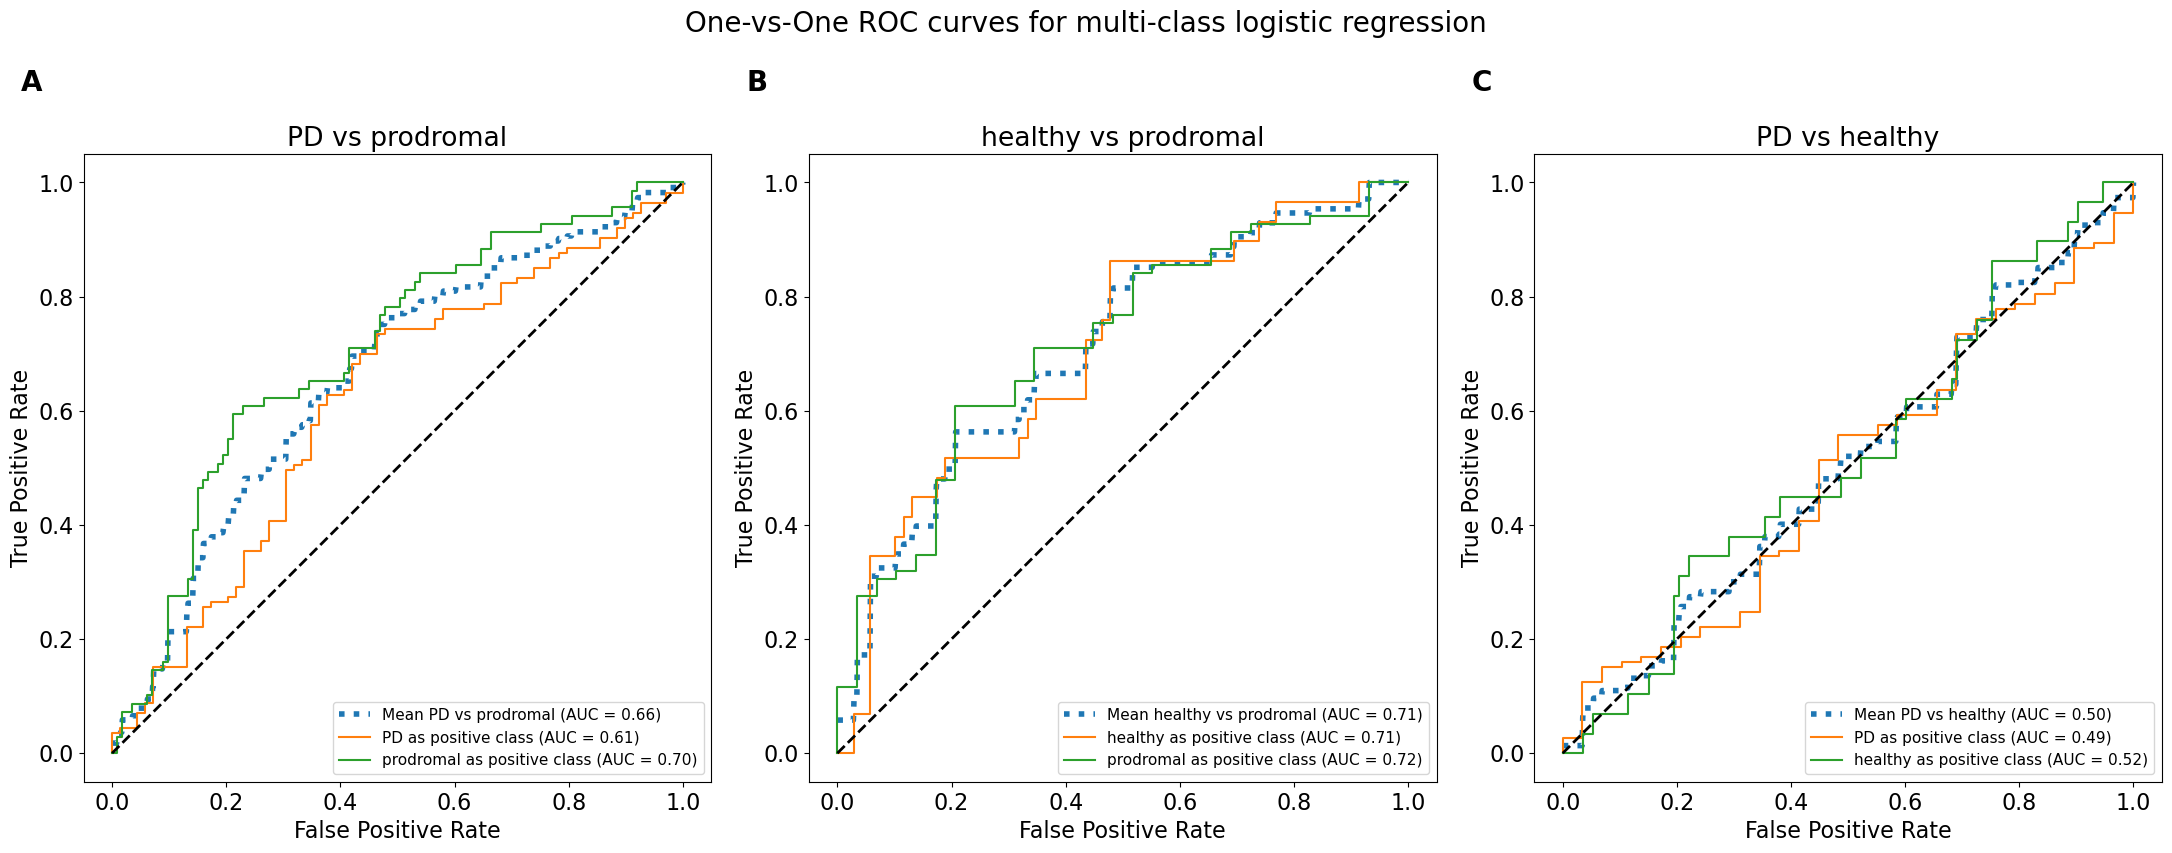

In [11]:
pair_scores = []
mean_tpr = dict()

matplotlib.rcParams.update({'font.size': 16})

fig, axes = plt.subplots(1, 3, figsize=(22, 9))
for (ix, (label_a, label_b)), ax, letter in zip(enumerate(pair_list), axes, ['A', 'B', 'C']):

    a_mask = y_test == label_a
    b_mask = y_test == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

    label_a = target_names[idx_a]
    label_b = target_names[idx_b]

    ax.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {label_a} vs {label_b} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        y_score[ab_mask, idx_a],
        ax=ax,
        name=f"{label_a} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        y_score[ab_mask, idx_b],
        ax=ax,
        name=f"{label_b} as positive class",
    )
    ax.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    ax.axis("square")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{target_names[idx_a]} vs {label_b}")
    ax.legend(loc='lower right', fontsize=11)
    ax.text(-0.1, 1.1, letter, transform=ax.transAxes, size=20, weight='bold')
fig.suptitle("One-vs-One ROC curves for multi-class logistic regression", fontsize=20)
fig.tight_layout()
fig.savefig('../figures/roc_ovo_multi_class_logistic_regression.png', dpi=600)
plt.show()

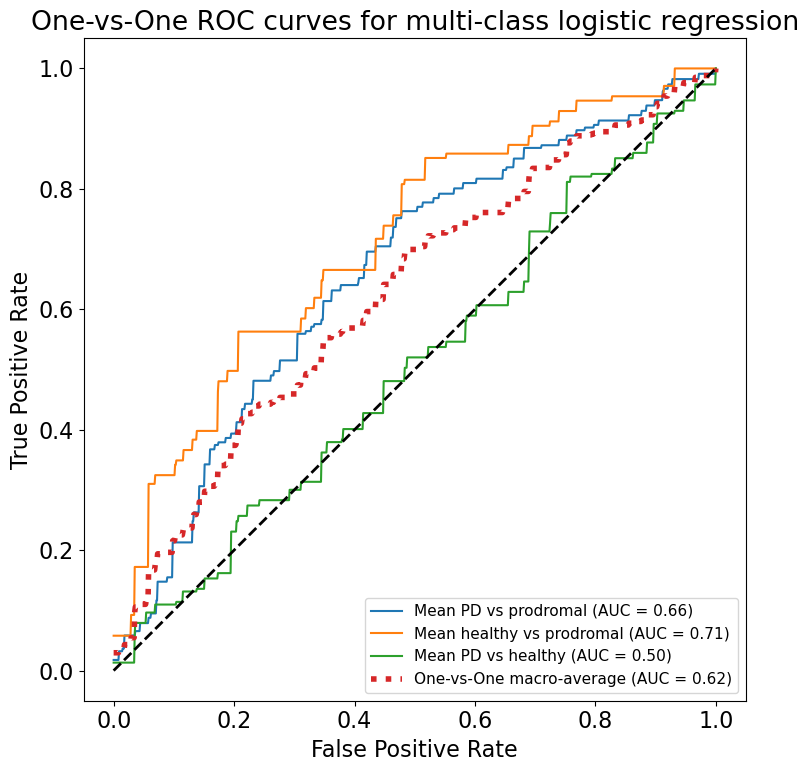

In [23]:
names = ['', 'PD', 'healthy', '', 'prodromal']
ovo_tpr = np.zeros_like(fpr_grid)

fig, ax = plt.subplots(figsize=(10, 8))
for ix, (label_a, label_b) in enumerate(pair_list):
    ovo_tpr += mean_tpr[ix]
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {names[label_a]} vs {names[label_b]} (AUC = {pair_scores[ix]:.2f})",
    )

ovo_tpr /= sum(1 for pair in enumerate(pair_list))

plt.plot(
    fpr_grid,
    ovo_tpr,
    label=f"One-vs-One macro-average (AUC = {np.average(pair_scores):.2f})",
    linestyle=":",
    linewidth=4,
)
ax.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
ax.axis("square")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("One-vs-One ROC curves for multi-class logistic regression")
ax.legend(loc='lower right', fontsize=11)
fig.tight_layout()
fig.savefig('../figures/roc_ovo_all_multi_class_logistic_regression.png', dpi=600)
plt.show()